# Exploring neighborhoods in Toronto

## Preparing the dataset

First we will install a library necessary for parsing HTML with Pandas:

In [3]:
!pip install lxml

In [4]:
import pandas as pd

Noe we can use **read_html** to get the dataframe from Wikipedia:

In [16]:
dfs = pd.read_html("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")
df = dfs[0] # first data frame is the table that we need
df.columns = ["Postal Code", "Borough", "Neighborhood"]
df

,Postal Code,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
...,...,...,...
175,M5Z,Not assigned,Not assigned
176,M6Z,Not assigned,Not assigned
177,M7Z,Not assigned,Not assigned
178,M8Z,Etobicoke,"Mimico NW, The Queensway West, South of Bloor,..."


### Cleaning the data

Let's remove rows without borough.

In [17]:
df = df[df["Borough"] != "Not assigned"] # remove rows without Borough
df

,Postal Code,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
...,...,...,...
160,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North"
165,M4Y,Downtown Toronto,Church and Wellesley
168,M7Y,East Toronto,"Business reply mail Processing Centre, South C..."
169,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu..."


Next we need to split the neighborhoods by comma into separate rows. For that we are gonna create an intermediate dataframe with Postal Code and Neighborhood and then merge it with the original one.

In [18]:
# split neighborhoods by commas
df_nh = pd.DataFrame(df.Neighborhood.str.split(',').tolist(), index=df["Postal Code"]).stack()
df_nh = df_nh.reset_index([0, "Postal Code"])
df_nh.columns = ["Postal Code", "Neighborhood"]
df_nh

,Postal Code,Neighborhood
0,M3A,Parkwoods
1,M4A,Victoria Village
2,M5A,Regent Park
3,M5A,Harbourfront
4,M6A,Lawrence Manor
...,...,...
212,M8Z,Mimico NW
213,M8Z,The Queensway West
214,M8Z,South of Bloor
215,M8Z,Kingsway Park South West


In [19]:
# build a final df by merging original and stacked
df_b = df.drop(columns=["Neighborhood"])
df_neighborhoods = pd.merge(df_b, df_nh, how="inner", on="Postal Code")
df_neighborhoods

,Postal Code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Regent Park
3,M5A,Downtown Toronto,Harbourfront
4,M6A,North York,Lawrence Manor
...,...,...,...
212,M8Z,Etobicoke,Mimico NW
213,M8Z,Etobicoke,The Queensway West
214,M8Z,Etobicoke,South of Bloor
215,M8Z,Etobicoke,Kingsway Park South West


Now we have 217 neighborhoods, each in its own row.

### Geocoding
To add coordinates we are going to use Geocoder Python library with free Arcgis provider.
We'll serialize the result with Pickle to avoid repeating this step, because it takes time.

In [20]:
!pip install geocoder

import geocoder

def geocode(address):
    g = geocoder.arcgis(address)
    return g.lat, g.lng

geocoded_file_name = "toronto_neighborhoods.pickle"

try:
    df_neighborhoods = pd.read_pickle(geocoded_file_name)
except:
    # add columns for Latitude and Longitude
    df_neighborhoods["Lat"] = None
    df_neighborhoods["Lng"] = None
    for index, row in df_neighborhoods.iterrows():
        # form address line (with UK in the end to avoid London in US and other funny coincidences)
        address = ", ".join([row["Neighborhood"], row["Borough"], row["Postal Code"], "Toronto", "Canada"])
        
        lat, lng = None, None
        while lat is None or lng is None:
            try:
                lat, lng = geocode(address)
            except:
                pass
        
        print(f"({index}){address}: {lat}, {lng}")
        row["Lat"] = lat
        row["Lng"] = lng    
    df_neighborhoods.to_pickle(geocoded_file_name)

### Map

In [26]:
import folium

lat, lng = geocode("Toronto, Canada")

# create map of Toronto
map_toronto = folium.Map(location=[lat, lng], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_neighborhoods['Lat'], df_neighborhoods['Lng'], df_neighborhoods['Borough'], df_neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

## Foursquare data
Let's get venues for every neighborhood using Foursquare API.

In [32]:
FOURSQUARE_CLIENT_ID = 'YQVQAU5W1H13Y1MDLCLZWOCR0TLTP3VC2MJR4RDYSVXAOFD1'
FOURSQUARE_CLIENT_SECRET = 'DB3XN2GZ55M2CKNMKHXCKAU3GZZI3SMGP1FA21CA3MCL1YEU'
FOURSQUARE_VERSION = '20200601'
FOURSQUARE_LIMIT = 100

import requests

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            FOURSQUARE_CLIENT_ID, 
            FOURSQUARE_CLIENT_SECRET, 
            FOURSQUARE_VERSION, 
            lat, 
            lng, 
            radius, 
            FOURSQUARE_LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

venues_file_name = "toronto_venues.pickle"
try:
    torronto_venues = pd.read_pickle(venues_file_name)
except:
    torronto_venues = getNearbyVenues(names=df_neighborhoods['Neighborhood'],
                                   latitudes=df_neighborhoods['Lat'],
                                   longitudes=df_neighborhoods['Lng']
                                  )
    torronto_venues.to_pickle(venues_file_name)
    
torronto_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.751880,-79.330360,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.751880,-79.330360,PetSmart,43.748639,-79.333488,Pet Store
2,Parkwoods,43.751880,-79.330360,Variety Store,43.751974,-79.333114,Food & Drink Shop
3,Parkwoods,43.751880,-79.330360,TTC stop - 44 Valley Woods,43.755402,-79.333741,Bus Stop
4,Victoria Village,43.730420,-79.312820,Memories of Africa,43.726602,-79.312427,Grocery Store
...,...,...,...,...,...,...,...
5134,Royal York South West,43.691042,-79.530451,Dollarama,43.691945,-79.531593,Discount Store
5135,Royal York South West,43.691042,-79.530451,Royal York Fruit Market,43.691494,-79.531471,Flea Market
5136,Royal York South West,43.691042,-79.530451,Baskin-Robbins,43.691547,-79.531702,Ice Cream Shop
5137,Royal York South West,43.691042,-79.530451,2 Bros Cuisine,43.692499,-79.531698,Middle Eastern Restaurant


**Let's find out how many unique categories can be curated from all the returned venues**

In [33]:
print('There are {} uniques categories.'.format(len(torronto_venues['Venue Category'].unique())))

There are 314 uniques categories.


## Analyze Each Neighborhood

In [129]:
# one hot encoding
toronto_onehot = pd.get_dummies(torronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = torronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Yoga Studio,Adult Boutique,African Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Animal Shelter,...,Vegetarian / Vegan Restaurant,Veterinarian,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Next, let's normalize the data**

In [176]:
toronto_normalized = toronto_onehot.groupby('Neighborhood').sum().reset_index()
toronto_normalized = toronto_normalized.set_index('Neighborhood', drop=True)
toronto_normalized = toronto_normalized.div(toronto_grouped.max())
toronto_normalized = toronto_normalized.drop(columns='Neighborhood').reset_index()
toronto_normalized

,Neighborhood,Adult Boutique,African Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Animal Shelter,...,Veterinarian,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Adelaide,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,Agincourt North,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Albion Gardens,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bathurst Quay,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Beaumond Heights,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,Willowdale,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
203,Woburn,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
204,Woodbine Heights,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
205,York Mills,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Now let's create the new dataframe and display the top 10 venues for each neighborhood.**

In [177]:
import numpy as np

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_normalized['Neighborhood']

for ind in np.arange(toronto_normalized.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_normalized.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adelaide,Coffee Shop,Café,Hotel,Restaurant,Asian Restaurant,Steakhouse,Sushi Restaurant,Gym,American Restaurant,Salad Place
1,Agincourt North,Sushi Restaurant,Pharmacy,Electronics Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant
2,Albion Gardens,Hockey Arena,Hardware Store,Gym Pool,Eastern European Restaurant,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore
3,Bathurst Quay,Coffee Shop,Café,Park,Japanese Restaurant,Tunnel,Garden,Diner,Bank,Caribbean Restaurant,Sculpture Garden
4,Beaumond Heights,Grocery Store,Fast Food Restaurant,Caribbean Restaurant,Sandwich Place,Fried Chicken Joint,Japanese Restaurant,Beer Store,Liquor Store,Discount Store,Park


## Cluster Neighborhoods
First, let's find an optimal K using silhouette method.

In [178]:
toronto_clustering = toronto_normalized.drop('Neighborhood', 1)

In [180]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

sil = []
K_sil = range(2,20)
# minimum 2 clusters required, to define dissimilarity
for k in K_sil:
    print(k, end=' ')
    kmeans = KMeans(n_clusters = k, random_state=42).fit(toronto_clustering)
    labels = kmeans.labels_
    sil.append(silhouette_score(toronto_clustering, labels, metric = 'euclidean'))

2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 

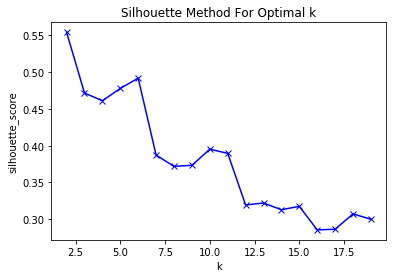

In [181]:
import matplotlib.pyplot as plt

plt.plot(K_sil, sil, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette_score')
plt.title('Silhouette Method For Optimal k')
plt.show()

In [183]:
# set number of clusters
kclusters = 6

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=42).fit(toronto_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[:10]

array([2, 1, 1, 1, 1, 1, 1, 5, 4, 1])

**Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.**

In [184]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = df_neighborhoods

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() # check the last columns!

,Postal Code,Borough,Neighborhood,Lat,Lng,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.7519,-79.3304,1.0,Food & Drink Shop,Bus Stop,Pet Store,Park,Yoga Studio,Dumpling Restaurant,Dive Bar,Dog Run,Doner Restaurant,Donut Shop
1,M4A,North York,Victoria Village,43.7304,-79.3128,1.0,Grocery Store,Nail Salon,Intersection,Yoga Studio,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
2,M5A,Downtown Toronto,Regent Park,43.6607,-79.3603,1.0,Coffee Shop,Thai Restaurant,Pub,Fast Food Restaurant,Electronics Store,Beer Store,Food Truck,Sushi Restaurant,Restaurant,Auto Dealership
3,M5A,Downtown Toronto,Harbourfront,43.6551,-79.3626,1.0,Coffee Shop,Breakfast Spot,Yoga Studio,Italian Restaurant,Pub,Restaurant,Distribution Center,Electronics Store,Event Space,Food Truck
4,M6A,North York,Lawrence Manor,43.7149,-79.4497,1.0,Discount Store,Fast Food Restaurant,Coffee Shop,Bookstore,Gym,Flower Shop,Gas Station,Sandwich Place,Restaurant,Metro Station


Finally, let's visualize the resulting clusters

In [185]:
toronto_merged = toronto_merged[toronto_merged["Cluster Labels"] >= 0]

In [186]:
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[lat, lng], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Lat'], toronto_merged['Lng'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Examine Clusters

### Cluster 0

In [188]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
56,North York,0.0,Clothing Store,Coffee Shop,Fast Food Restaurant,Japanese Restaurant,Restaurant,Convenience Store,Toy / Game Store,Women's Store,Shoe Store,Tea Room
57,North York,0.0,Clothing Store,Fast Food Restaurant,Coffee Shop,Restaurant,Toy / Game Store,Women's Store,Juice Bar,Bank,Tea Room,Shoe Store
58,North York,0.0,Clothing Store,Fast Food Restaurant,Coffee Shop,Restaurant,Toy / Game Store,Women's Store,Juice Bar,Bank,Tea Room,Shoe Store
120,Scarborough,0.0,Clothing Store,Restaurant,Tea Room,Cosmetics Shop,Toy / Game Store,Movie Theater,Supermarket,Discount Store,Department Store,Bank


Looks like **Shopping**.

### Cluster 1

In [190]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,North York,1.0,Food & Drink Shop,Bus Stop,Pet Store,Park,Yoga Studio,Dumpling Restaurant,Dive Bar,Dog Run,Doner Restaurant,Donut Shop
1,North York,1.0,Grocery Store,Nail Salon,Intersection,Yoga Studio,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
2,Downtown Toronto,1.0,Coffee Shop,Thai Restaurant,Pub,Fast Food Restaurant,Electronics Store,Beer Store,Food Truck,Sushi Restaurant,Restaurant,Auto Dealership
3,Downtown Toronto,1.0,Coffee Shop,Breakfast Spot,Yoga Studio,Italian Restaurant,Pub,Restaurant,Distribution Center,Electronics Store,Event Space,Food Truck
4,North York,1.0,Discount Store,Fast Food Restaurant,Coffee Shop,Bookstore,Gym,Flower Shop,Gas Station,Sandwich Place,Restaurant,Metro Station
...,...,...,...,...,...,...,...,...,...,...,...,...
212,Etobicoke,1.0,Yoga Studio,Bakery,Bar,Fish Market,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant
213,Etobicoke,1.0,Bank,Optical Shop,Gym,Asian Restaurant,Clothing Store,Thai Restaurant,Restaurant,Grocery Store,Gym / Fitness Center,Fish & Chips Shop
214,Etobicoke,1.0,Liquor Store,Park,Breakfast Spot,Dessert Shop,Sushi Restaurant,Restaurant,Bank,Coffee Shop,Bar,Pub
215,Etobicoke,1.0,Park,Kids Store,River,Dumpling Restaurant,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore


This cluster has a variety of everything and spread arond the most of the town, so let's call it **Common city area**.

### Cluster 2

In [191]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
38,Downtown Toronto,2.0,Coffee Shop,Café,Italian Restaurant,Restaurant,Japanese Restaurant,Seafood Restaurant,Gym,Gastropub,Hotel,Bakery
50,Downtown Toronto,2.0,Coffee Shop,Hotel,Café,Clothing Store,Restaurant,Gym,Thai Restaurant,Pizza Place,Bookstore,Steakhouse
51,Downtown Toronto,2.0,Coffee Shop,Café,Hotel,Restaurant,Asian Restaurant,Steakhouse,Sushi Restaurant,Gym,American Restaurant,Salad Place
64,Downtown Toronto,2.0,Coffee Shop,Café,Hotel,Breakfast Spot,Concert Hall,Japanese Restaurant,Restaurant,American Restaurant,Steakhouse,Bakery
75,Downtown Toronto,2.0,Coffee Shop,Hotel,Café,Seafood Restaurant,Salad Place,American Restaurant,Restaurant,Japanese Restaurant,Beer Bar,Tea Room
76,Downtown Toronto,2.0,Coffee Shop,Hotel,Café,Japanese Restaurant,Restaurant,Salad Place,Seafood Restaurant,Italian Restaurant,American Restaurant,Tea Room
88,Downtown Toronto,2.0,Coffee Shop,Restaurant,Hotel,Italian Restaurant,Café,Japanese Restaurant,American Restaurant,Gym,Gastropub,Seafood Restaurant
89,Downtown Toronto,2.0,Coffee Shop,Restaurant,Hotel,Café,Italian Restaurant,American Restaurant,Gym,Japanese Restaurant,Seafood Restaurant,Beer Bar
188,Downtown Toronto,2.0,Coffee Shop,Hotel,Café,Concert Hall,Taco Place,Tea Room,Bar,Thai Restaurant,Theater,Restaurant
196,Downtown Toronto,2.0,Coffee Shop,Hotel,Café,Restaurant,Gym,Japanese Restaurant,Deli / Bodega,Steakhouse,American Restaurant,Seafood Restaurant


Definitely a **Touristic** area.

### Cluster 3

In [193]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
15,Downtown Toronto,3.0,Coffee Shop,Clothing Store,Hotel,Japanese Restaurant,Italian Restaurant,Cosmetics Shop,Café,Bookstore,Bubble Tea Shop,Tea Room
16,Downtown Toronto,3.0,Coffee Shop,Clothing Store,Hotel,Japanese Restaurant,Italian Restaurant,Cosmetics Shop,Café,Bookstore,Bubble Tea Shop,Tea Room
42,Downtown Toronto,3.0,Coffee Shop,Clothing Store,Hotel,Middle Eastern Restaurant,Electronics Store,Bubble Tea Shop,Theater,Diner,Department Store,Plaza


Probably a **Downtown shopping**.

### Cluster 4

In [194]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
54,West Toronto,4.0,Café,Bar,Coffee Shop,Mediterranean Restaurant,Restaurant,Pub,Bakery,Comedy Club,Music Store,Music Venue
66,West Toronto,4.0,Bar,Restaurant,Café,Coffee Shop,Vegetarian / Vegan Restaurant,Bakery,Cocktail Bar,Sandwich Place,Portuguese Restaurant,Mexican Restaurant
67,West Toronto,4.0,Men's Store,Bar,Coffee Shop,Yoga Studio,Park,Bakery,Boutique,Vietnamese Restaurant,Diner,Art Gallery
77,West Toronto,4.0,Coffee Shop,Bar,Grocery Store,Café,Boutique,Bakery,Pizza Place,Vietnamese Restaurant,Restaurant,Middle Eastern Restaurant
147,Downtown Toronto,4.0,Café,Sandwich Place,Coffee Shop,Restaurant,Bakery,Pizza Place,Bar,Italian Restaurant,Sushi Restaurant,Bookstore
155,Downtown Toronto,4.0,Bar,Café,Coffee Shop,Pizza Place,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Mexican Restaurant,Grocery Store,Dessert Shop,Gaming Cafe
156,Downtown Toronto,4.0,Café,Pizza Place,Coffee Shop,Dumpling Restaurant,Burger Joint,Mexican Restaurant,Vietnamese Restaurant,Grocery Store,Vegetarian / Vegan Restaurant,Park
157,Downtown Toronto,4.0,Chinese Restaurant,Café,Coffee Shop,Art Gallery,Tea Room,Korean Restaurant,French Restaurant,Dumpling Restaurant,Noodle House,Japanese Restaurant


Dominant by **Downtown restaurants**

### Cluster 5

In [195]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 5, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Downtown Toronto,5.0,Coffee Shop,Sandwich Place,Café,Italian Restaurant,College Cafeteria,Smoothie Shop,Bank,Bar,Sushi Restaurant,Fried Chicken Joint
7,Downtown Toronto,5.0,Coffee Shop,Sandwich Place,Park,Café,Persian Restaurant,Office,Museum,Salon / Barbershop,Music School,Music Store
28,Downtown Toronto,5.0,Coffee Shop,Grocery Store,Market,Filipino Restaurant,Bank,Bar,Library,Bistro,Food & Drink Shop,Breakfast Spot
63,Downtown Toronto,5.0,Coffee Shop,Hotel,Japanese Restaurant,Plaza,Deli / Bodega,Boat or Ferry,Park,Greek Restaurant,IT Services,Steakhouse
73,East Toronto,5.0,Greek Restaurant,Pub,Italian Restaurant,Coffee Shop,Furniture / Home Store,Ice Cream Shop,Restaurant,Burger Joint,Sushi Restaurant,Juice Bar
100,East Toronto,5.0,Diner,Italian Restaurant,Brewery,Coffee Shop,Gastropub,Pet Store,Café,Bakery,Bar,American Restaurant
115,York,5.0,Coffee Shop,Pizza Place,Bus Line,Sandwich Place,Park,Gas Station,Pharmacy,Indian Restaurant,Fried Chicken Joint,Discount Store
136,Central Toronto,5.0,Italian Restaurant,Boutique,Spa,Coffee Shop,Restaurant,Café,Clothing Store,Hotel,French Restaurant,Shopping Mall
138,West Toronto,5.0,Coffee Shop,Bakery,Grocery Store,Eastern European Restaurant,Sushi Restaurant,Café,Thai Restaurant,American Restaurant,Bookstore,Breakfast Spot
146,Downtown Toronto,5.0,Coffee Shop,Café,Pub,Gym,Restaurant,Concert Hall,Museum,Italian Restaurant,Boutique,Park


We can see mostly **Restaurants** here, scattered around the city.